In [181]:
import networkx as nx
import itertools
import numpy as np
import scipy as sp
import random
import timeit
from matplotlib import pyplot as plt
import distanceclosure as dc

$$ D = \frac{2 |E|}{|V|(|V| -1)}$$

In [2]:
def weighten(G):
    for (u, v, w) in G.edges(data=True):
        w['weight'] = np.random.uniform()
    return G

In [121]:
def path_to_edge_list(p):
    return [(p[i], p[i+1]) for i in range(len(p)-1)]
    
def all_pairs_shortest_path_subgraph(H):
    G = H.copy()
    edgelist = set()
    apsp = dict(nx.all_pairs_dijkstra_path(G))
    for (i, j) in itertools.combinations(range(G.number_of_nodes()), 2):
        edgelist.update(path_to_edge_list(apsp[i][j]))
    
    return G.edge_subgraph(edgelist)

def all_pairs_shortest_path_subgraph2(H):
    G = H.copy()
    apsp_len = dict(nx.all_pairs_dijkstra_path_length(G))
    non_apsp_edges = []
    for (u, v, w) in G.edges(data=True):
        if w['weight'] > apsp_len[u][v]:
            non_apsp_edges.append((u, v))
    G.remove_edges_from( non_apsp_edges)
    return G

In [188]:
V = 1000
D = 0.01
E = round(D*V*(V-1)/2)

assert round(E / V) == 5

G = nx.barabasi_albert_graph(V, round(E/V))
G = weighten(G)
print(G.number_of_edges())

4975


In [189]:
N = 1000

In [191]:
start = timeit.default_timer()
for _ in range(30):
    g = nx.laplacian_spectrum(G)
print(f'Time: {timeit.default_timer() - start:.2f} s')

Time: 6.34 s


In [192]:
start = timeit.default_timer()
for _ in range(30):
    g = sp.sparse.linalg.eigsh(nx.laplacian_matrix(G, 
                                                      weight='weight'), k = N-1, return_eigenvectors=False)
print(f'Time: {timeit.default_timer() - start:.2f} s')

Time: 38.14 s


In [187]:
start = timeit.default_timer()
Distances = []

for _ in range(10):
    distances = []
    #g = nx.laplacian_spectrum(G)
    g = sp.sparse.linalg.eigsh(nx.laplacian_matrix(G, 
                                                      weight='weight'), k = N-1, return_eigenvectors=False)
    distances.append(np.linalg.norm(g-g))
    H = G.copy()
    for _ in range(N):
        H.remove_edge(*random.choice(list(H.edges)))
        #h = nx.laplacian_spectrum(H)
        h = sp.sparse.linalg.eigsh(nx.laplacian_matrix(H, 
                                                      weight='weight'), k = N-1, return_eigenvectors=False)
        distances.append(np.linalg.norm(g-h))
    Distances.append(distances)
    print(f'Time: {timeit.default_timer() - start:.0f} s')

KeyboardInterrupt: 

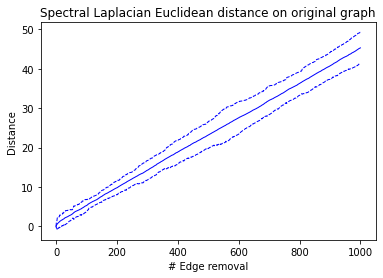

In [10]:
x = np.array(range(N+1))
m = np.mean(Distances, axis=0)
s = np.std(Distances, axis=0)
plt.plot(x, m, color='b', linewidth=1, label='mean')
plt.plot(x, m + 3*s, color='b', linewidth=1, linestyle='--', label='mean + 3 std')
plt.plot(x, m - 3*s, color='b', linewidth=1, linestyle='--', label='mean - 3 std')
plt.title('Spectral Laplacian Euclidean distance on original graph')
plt.xlabel('# Edge removal')
plt.ylabel('Distance')
plt.savefig('Spectral Laplacian Euclidean distance on original graph.png', dpi=200)

In [151]:
start = timeit.default_timer()
apsp_G = all_pairs_shortest_path_subgraph(G)
print(f'Time: {timeit.default_timer() - start:.0f} s')
print(apsp_G)

Time: 20 s
Graph with 1000 nodes and 2659 edges


In [152]:
start = timeit.default_timer()
apsp_G2 = all_pairs_shortest_path_subgraph2(G)
print(f'Time: {timeit.default_timer() - start:.0f} s')
print(apsp_G2)

Time: 16 s
Graph with 1000 nodes and 2659 edges


In [156]:
start = timeit.default_timer()
apsp_G3 = dc.metric_backbone(G, weight='weight')
print(f'Time: {timeit.default_timer() - start:.0f} s')
print(apsp_G3)

Time: 12 s
Graph with 1000 nodes and 2659 edges


In [155]:
assert nx.utils.graphs_equal(apsp_G, apsp_G2)

assert nx.utils.graphs_equal(apsp_G, apsp_G3)

{(0, 1): Text(0.2983974204340721, 0.5611015940436134, '0.85'),
 (0, 2): Text(0.36071037750046914, 0.21787482757676566, '0.16'),
 (0, 3): Text(0.6239088529796306, 0.10165930153596747, '0.44'),
 (1, 4): Text(-0.4394060014529897, 0.15413257153345244, '0.61'),
 (1, 5): Text(-0.27517262222045236, -0.24778193917413932, '0.24'),
 (1, 7): Text(-0.4589934592524621, 0.6070680066438097, '0.8'),
 (2, 3): Text(0.2268778643906515, -0.29823293732277223, '0.62'),
 (2, 5): Text(-0.2128596651540553, -0.5910087056409871, '0.71'),
 (2, 6): Text(0.38871670472496994, -0.11064181888736874, '0.74'),
 (2, 7): Text(-0.39668050218606504, 0.263841240176962, '0.64'),
 (3, 4): Text(-0.11389456890743122, -0.30530972097419345, '0.45'),
 (3, 6): Text(0.6519151802041314, -0.22685734492816692, '0.94')}

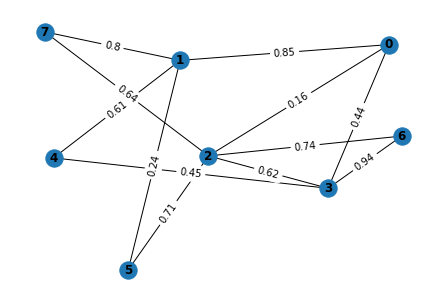

In [130]:
#https://networkx.org/documentation/latest/auto_examples/drawing/plot_weighted_graph.html#sphx-glr-auto-examples-drawing-plot-weighted-graph-py
    
edge_labels = {k : round(v, 2) for (k, v) in nx.get_edge_attributes(G,'weight').items()}
pos = nx.spring_layout(G, seed=4)
nx.draw(G, pos=pos, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)